# Trabajo Práctico 1: Reservas de Hotel

<hr width="50%" align="left"/>

<br/>

# Clasificación - Entrenamiento y Predicción
## **Checkpoint 2 - "Árbol de Decisión"**

<br/>

## **Grupo:** 03 - **_"Hackers Panas"_**

<br/>

## **Integrantes:**

<p>
<img align="left" src="https://github.com/NLGS2907.png" height=50 width=50 />

### [Franco Lighterman Reismann](https://github.com/NLGS2907) (106714)
<br/>
</p>

<p>
<img align="left" src="https://github.com/MarcosGN.png" height=50 width=50 />

### [Marcos García Neira](https://github.com/MarcosGN) (110363)
<br/>
</p>

<p>
<img align="left" src="https://github.com/mmaddalena.png" height=50 width=50 />

### [Martín Andrés Madalena](https://github.com/mmaddalena) (107610)
</p>

<br/><br/><br/><br/>
<hr/>

# **Instalaciones e _imports_ de librerías y otras dependencias.**

Instalaciones con `pip`, y otros _imports_ de uso global, para que estén en un sólo lado.

In [25]:
# No queremos ver la salida de pip
%%capture
# ---------- #

%pip install "dtreeviz"

In [26]:
# Procesamiento de datos
import numpy as np
import pandas as pd

# Herramientas de visualización
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz

# sklearn
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (precision_score, recall_score, accuracy_score, f1_score, make_scorer,
                             confusion_matrix, classification_report)
from sklearn.preprocessing import OneHotEncoder

# type hinting
from typing import Literal, Optional, TYPE_CHECKING, Union
if TYPE_CHECKING:
    from os import PathLike

# Otros
from IPython.display import display # preferible a print()
from pathlib import Path
from warnings import simplefilter
from google.colab import drive

simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<hr/>

# **Preprocesamiento de Datos**

Primero importamos el dataset:

In [27]:
# train = pd.read_csv("../Datasets/hotels_train.csv")
# tests = pd.read_csv("../Datasets/hotels_test.csv")
train = pd.read_csv("https://raw.githubusercontent.com/NLGS2907/7506R-2C2023-GRUPO03/master/TPs/TP1/Datasets/hotels_train.csv")
tests = pd.read_csv("https://raw.githubusercontent.com/NLGS2907/7506R-2C2023-GRUPO03/master/TPs/TP1/Datasets/hotels_test.csv")

In [28]:
# Variables de uso global
variables_categoricas = ["hotel", "arrival_date_month", "meal", "country", "market_segment", "distribution_channel",
                         "is_repeated_guest", "reserved_room_type", "assigned_room_type", "deposit_type", "agent",
                         "company", "customer_type", "is_canceled"] # id no se deja a propósito
variables_cuantitativas = [categoria for categoria in train.columns if categoria not in variables_categoricas + ["id"]]

Y luego le aplicamos rápidamente todos los tratamientos explicados en detalle en la [notebook](https://github.com/NLGS2907/7506R-2C2023-GRUPO03/blob/4426ce7a86d5d9d53d44b14116cc443c6f27f016/TPs/TP1/Checkpoint%201/7506R_TP1_GRUPO03_CHP1_ENTREGA.ipynb) y el [reporte](https://github.com/NLGS2907/7506R-2C2023-GRUPO03/blob/4426ce7a86d5d9d53d44b14116cc443c6f27f016/TPs/TP1/Checkpoint%201/7506R_TP1_GRUPO03_CHP1_REPORTE.pdf) del _checkpoint_ 1 a ambos datasets:

In [29]:
def tratamiento_chp1(df: pd.DataFrame,
                     *,
                     borrar_filas: bool=True,
                     borrar_columnas: bool=True,
                     imputaciones: bool=True) -> pd.DataFrame:
    """
    Realiza en forma rápida un resumen de todos los tratamientos explicados en el checkpoint 1
    a un DataFrame. Devuelve una copia sin afectar el original.
    -
    'borrar_filas': Si realizar los trabajos que borran filas o no.

    'borrar_columnas': Si realizar los trabajos que borran columnas o no.

    'imputaciones': Si realizar trabajos de imputaciones con el valor más frecuente.
    """

    df_copia = df.copy()

    # Eliminación de registros incompletos
    if borrar_columnas:
        df_copia = df_copia.drop(columns=["company"])

    if borrar_filas:
        df_copia = df_copia.dropna(axis="index", subset=["children", "country"])
    # ------------------------------ #

    # Imputación simple de datos
    if imputaciones:
        columnas_con_nulos = df.columns[df.isna().any()].tolist()
        imputador = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
        datos_imputados = imputador.fit_transform(df_copia)
        df_imp = pd.DataFrame(data=datos_imputados,
                            index=df_copia.index,
                            columns=df_copia.columns)
        for col in columnas_con_nulos:
            if col in df_copia.columns: # que no llore si ya fue borrado
                df_copia[col] = df_imp[col]
        df_copia.reset_index(drop=True) # para hacer coincidir de nuevo los números del índice
    # ------------------------------ #

    # Creación de columnas personalizadas
    if "people" not in df_copia.columns:
        df_copia.insert(11, "people", (df_copia["adults"] + df_copia["children"] + df_copia["babies"]).astype(int))
    # ------------------------------ #

    # Conversión a enteros de columnas pertinentes
    for categoria in ["children", "agent"]:
        df_copia[categoria] = df_copia[categoria].astype(int)
    # ------------------------------ #

    # Valores Atípicos
    if borrar_filas:
        if df_copia["adr"][df_copia["adr"] <= 0].count() != 0:
            df_copia.drop(df_copia[df_copia["adr"] <= 0].index, inplace=True)

        if df_copia["adults"][df_copia["adults"] == 0].count() != 0:
            df_copia.drop(df_copia[df_copia["adults"] == 0].index, inplace=True)

        if df_copia["people"][df_copia["people"] > 5].count() != 0:
            df_copia.drop(df_copia[df_copia["people"] > 5].index, inplace=True)

        if df_copia[(df_copia["is_repeated_guest"] == 0) &
                    (df_copia["previous_bookings_not_canceled"] != 0)].shape[0] != 0:
            df_copia.drop(df_copia[(df_copia["is_repeated_guest"] == 0) &
                                   (df_copia["previous_bookings_not_canceled"] != 0)].index, inplace=True)
    # ------------------------------ #

    return df_copia

In [30]:
df_chp2 = tratamiento_chp1(train)

Al dataset de testeo es pertinente hacerle un análisis exploratorio propio igual, pues podría contener características distintas al de entrenamiento.

In [31]:
display(tests.head())
fil, col = tests.shape
print(f"El DataFrame tiene {fil} filas y {col} columnas.")
display(tests.columns.to_list())

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,id
0,City Hotel,277,2016,November,46,7,1,2,2,0.0,...,Non Refund,NaN,NaN,0,Transient,100.0,0,0,2016-04-04,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e
1,City Hotel,286,2016,May,20,11,0,4,2,0.0,...,No Deposit,30.0,NaN,176,Transient-Party,101.0,0,0,2016-01-22,aba9aac2-4495-4645-a60e-90328713c999
2,City Hotel,0,2016,August,35,23,0,1,3,0.0,...,No Deposit,NaN,NaN,0,Transient,225.0,0,2,2016-08-24,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad
3,Resort Hotel,196,2016,October,44,29,2,5,2,2.0,...,No Deposit,240.0,NaN,0,Transient,96.0,0,0,2016-11-05,ce1b400e-afa1-4946-bdff-004b859eb61c
4,Resort Hotel,232,2016,November,48,26,2,1,2,0.0,...,Non Refund,11.0,NaN,0,Transient,30.0,0,0,2016-10-18,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214


El DataFrame tiene 26535 filas y 31 columnas.


['hotel',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'agent',
 'company',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'reservation_status_date',
 'id']

Efectivamente, no tamos que `tests` carece de `is_canceled`. Sin embargo, a diferencia de `train` o `df_chp2`, tiene una variable nueva `reservation_status_date`.
Si nos guiamos por el _paper_, esta variable está destinada a usarse junto con _reservationStatus_ (o `reservation_status` en nuestra convención) para determinar en qué fecha se cambió el estado de la reserva. Ya se vió en el checkpoint 1 pero, no hay tal variable `reservation_status` o similar.

Por eso, nos gustaría resaltar que **despreciaremos toda columna no presente en el dataset de entrenamiento,** habiendo dos razones principales:

* Primeramente, hay variables como esta que **son irrelevantes de por sí.**
* Segundo, aún si contuvieran información útil, **no podemos cambiar el modelo de entrenamiento por cada conjunto de testeo que introduzca nueva información:** el modelo _"tiene que predecir en base a lo que ya sabe"._

In [32]:
def reducir_columnas(df_reductor: pd.DataFrame, df_a_reducir: pd.DataFrame) -> pd.DataFrame:
    """
    Quita todas las columnas de 'df_a_reducir' que no estén presentes en 'df_reductor'.
    """

    categorias = df_a_reducir.columns.to_list() # hacemos una copia de la lista para no mutar mientras recorremos
    df_reducido = df_a_reducir.copy()

    for categoria in categorias:
        if categoria not in df_reductor.columns:
            df_reducido.drop(categoria, axis="columns", inplace=True)

    return df_reducido

In [33]:
# No podemos borrar filas, porque kaggle espera un formato mismo número de filas que el total
df_tests = reducir_columnas(df_chp2, tests)

<hr/>

# **Creación de Árboles de Predicción**

In [34]:
def get_df_dummies(df: pd.DataFrame,
                   *,
                   variables_indeseadas: tuple[str, ...]=("company", "id", "is_canceled"),
                   metodo: Literal["ohe", "pd"]="ohe"
) -> pd.DataFrame:
    """
    Consigue una versión con dummies de un Dataframe, con reglas personalizadas.
    -
    'df': El DataFrame sobre el cual trabajar.

    'variables_indeseadas': Variables categóricas, pero que igual no deberían tenerse en cuenta
                            para el cálculo.

    'metodo': El método para generar los dummies:
                - 'ohe' utiliza `sklearn.preprocessing.OneHotEncoder()`
                - 'pd' utiliza `pandas.get_dummies()`
    """

    if metodo not in ("ohe", "pd"):
        raise ValueError(f"Argumento metodo='{metodo}' no válido. Debe ser 'ohe' o 'pd'.")

    categorias = variables_categoricas.copy()
    for var in variables_indeseadas:
        if var in categorias:
            categorias.remove(var)

    if metodo == "ohe":
        ohe = OneHotEncoder(sparse_output=False, dtype=int).set_output(transform="pandas")
        return pd.concat([df.drop(categorias, axis="columns"), # df sólo con las cuantitativas
                          ohe.fit_transform(df[categorias])], # df con las cualitativas dummies
                         axis="columns")
    elif metodo == "pd":
        return pd.get_dummies(df, columns=categorias)

In [35]:
def split_in_axes(df: pd.DataFrame,
                  *,
                  x_innecesarias: tuple[str, ...]=("id", "is_canceled"),
                  target: Optional[str]=None
) -> pd.DataFrame:
    """
    Devuelve los ejes a entrenar/testear de un DataFrame.
    -
    'x_innecesarias': Qué columnas no incluir en el split del eje X.

    'target': La variable objetivo que terminará en el split del eje Y.
              El target también es eliminado, si se puede, del split del eje X.
    """

    if target is not None and target not in x_innecesarias:
        x_innecesarias.append(target)

    df_x = df.copy()
    for indeseada in x_innecesarias:
        if indeseada in df.columns:
            df_x = df_x.drop(indeseada, axis="columns", inplace=False)

    df_y = (None if target is None else df[target].copy())

    return df_x, df_y

Primero creamos los _splits_ del dataset de entrenamiento:

In [36]:
train_dummies = get_df_dummies(df_chp2)
train_dummies_x, train_dummies_y = split_in_axes(train_dummies, target="is_canceled")
semilla = 3

x_train, x_test, y_train, y_test = train_test_split(train_dummies_x,
                                                    train_dummies_y,
                                                    test_size=0.15,
                                                    stratify=train_dummies_y,
                                                    random_state=semilla)

Y luego buscamos el mejor árbol mediante _cross validation_.

Nos guiamos principalmente por la métrica de _F1 Score_, ya que es el que se utiliza en la competencia de Kaggle.

In [37]:
def cross_val(metodo: Literal["random", "grid"]="grid",
              *,
              rand_comb: int=10,
              folds: int=10,
              kfold_estratificado: bool=True,
              seed: Optional[int]=None) -> Union[RandomizedSearchCV, GridSearchCV]:
    """
    Realiza cross validation con parámetros dados.
    -
    'metodo': Con qué metodo realizar el trabajo:
                - 'random' es para utilizar `sklearn.model_selection.RandomizedSearchCV`
                - 'grid' es para utilizar `sklearn.model_selection.GridSearchCV`

    'rand_comb': Cantidad de combinaciones a probar si se elige el método 'random'.

    'folds': Cantidad de folds a usar en el KFold.

    'kfold_estratificado': Si utilizar `sklearn.model_selection.StratifiedKFold` o
                           `sklearn.model_selection.KFold`.

    'seed': La semilla para resultados determinísticos.
    """

    if metodo not in ("random", "grid"):
        raise ValueError(f"Argumento metodo='{metodo}' no válido. Debe ser 'random' o 'grid'.")

    # Conjunto de parámetros que quiero usar en cada árbol
    params = {"criterion": ["gini", "entropy"],
              "min_samples_split": np.arange(2, 16),
              "max_depth": np.arange(13, 21)}

    # Kfold estratificado
    if kfold_estratificado:
        kfoldcv = StratifiedKFold(n_splits=folds)
    else:
        kfoldcv = KFold(n_splits=folds)

    # Clasificador
    arbol_base = DecisionTreeClassifier(random_state=seed)

    # Metrica que quiero optimizar F1 Score
    scorer_fn = make_scorer(f1_score)

    if metodo == "random": # Random Search Cross Validation
        return RandomizedSearchCV(estimator=arbol_base,
                                  param_distributions=params,
                                  scoring=scorer_fn,
                                  cv=kfoldcv,
                                  n_iter=rand_comb,
                                  n_jobs=-1,
                                  random_state=seed)

    if metodo == "grid": # Grid Search Cross Validation
        return GridSearchCV(estimator=arbol_base,
                            param_grid=params,
                            scoring=scorer_fn,
                            cv=kfoldcv,
                            n_jobs=-1,
                            return_train_score=True)

Es acá que trataremos de optimizar los hiperparámetros mediante _k-fold Cross Validation_. Elegimos **12** folds para esta tarea.

In [38]:
## ----- Tarda mucho. Sólo descomentar al utilizar el CV -----

# cv = cross_val(metodo="grid",
#                rand_comb=10,
#                folds=12,
#                kfold_estratificado=False,
#                seed=semilla)
# cv.fit(X=x_train,
#        y=y_train)

# print(cv.best_params_)
# print(cv.best_score_)

In [39]:
# --- Árbol creado manualmente ---
arbol = DecisionTreeClassifier(criterion="gini",
                               max_depth=17,
                               min_samples_split=3,
                               random_state=semilla)
# --------------------------------

# --- Árbol del CV ---
# cv.best_params_.update({"random_state": semilla})
# arbol = DecisionTreeClassifier().set_params(**cv.best_params_)
# --------------------

modelo = arbol.fit(X=x_train,
                   y=y_train)

Graficamos el árbol creado:

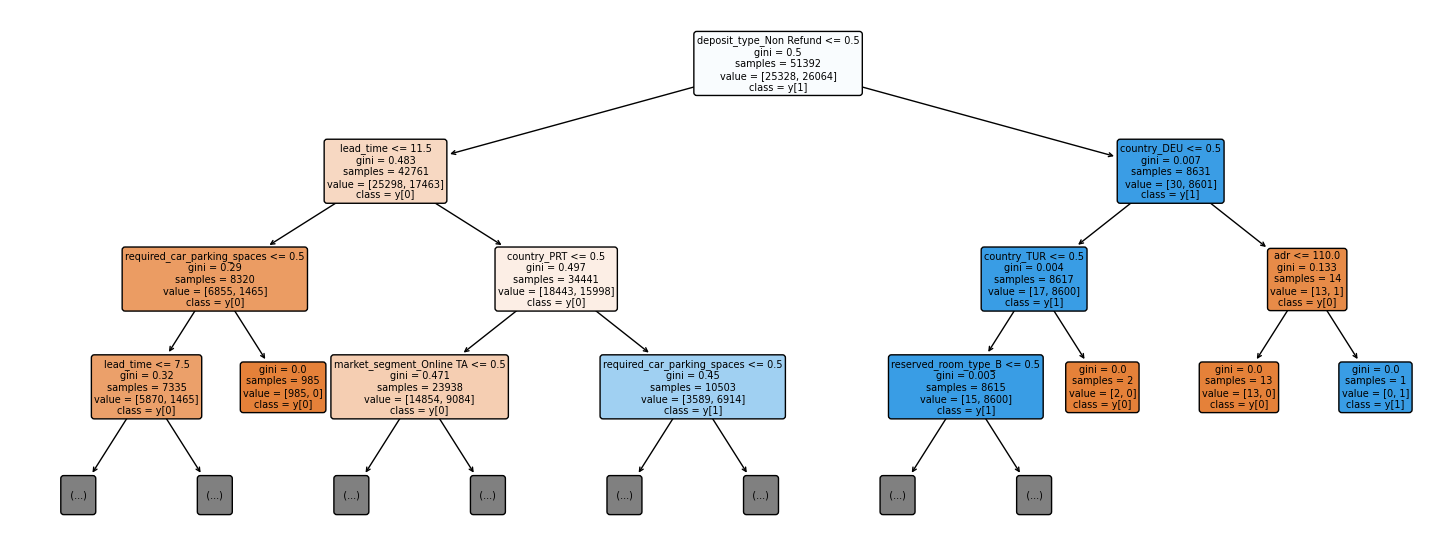

In [64]:
# por sklearn
plt.figure(figsize=(18.5, 7))
plt.suptitle("Árbol de decisión: Mejor Iteración")
plot_arbol = plot_tree(modelo,
                       max_depth=3,
                       feature_names=x_train.columns.to_list(),
                       filled=True,
                       rounded=True,
                       fontsize=7,
                       class_names=True)

plt.show(plot_arbol)

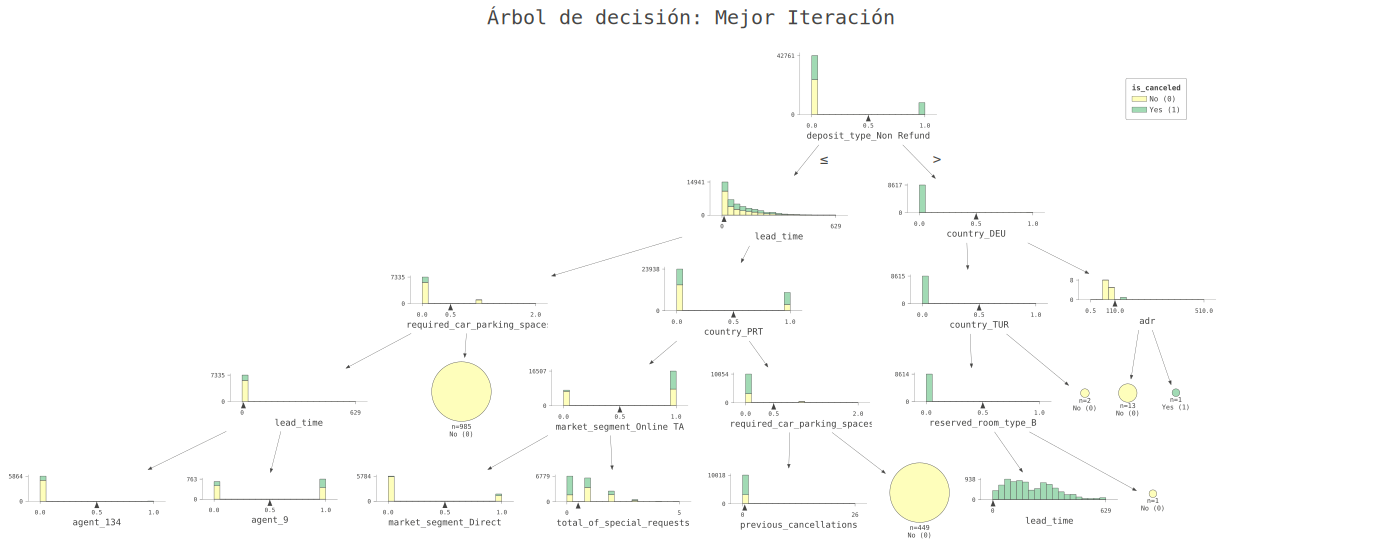

In [81]:
# por dtreeviz
viz_model = dtreeviz.model(modelo,
                           X_train=x_train, y_train=y_train,
                           feature_names=x_train.columns.to_list(),
                           target_name="is_canceled",
                           class_names=["No (0)", "Yes (1)"])

viz_model.view(depth_range_to_display=(0, 4), # Hasta el 5to nivel
               fontname="monospace", # Para que no llore con Arial
               title="Árbol de decisión: Mejor Iteración",
               title_fontsize=20)

Como podemos ver, comprueba primero si el tipo de reserva es del tipo que considera un reembolso. La gran mayoría se concentra en que _no son_ del tipo "Non Refund", pero los pocos datos que sí lo son, terminan siendo casi totalmente de los que se cancelan.
A partir de acá:
* Por la derecha, parece derivarse en averiguar de qué país viene mientras se saca de encima los candidatos que no cancelan con preguntas como cuánto pagó por día (el `adr`) o el tipo de habitación reservada.
* Por la izquierda es donde se derivan la mayoría de los datos, y se va haciendo preguntas como qué tan adelante hacen la reserva (en relación al _check-in_), o si requieren de espacios para estacionar.

<hr width="50%" align="left" />

Evaluamos el rendimiento:

In [82]:
y_pred = modelo.predict(x_test)

In [83]:
print(f"Semilla:\t{semilla}\n-")
print(f"Accuracy:\t{accuracy_score(y_test, y_pred)}\n"
      f"Recall:\t\t{recall_score(y_test, y_pred)}\n"
      f"Precision:\t{precision_score(y_test, y_pred)}\n"
      f"f1 score:\t{f1_score(y_test, y_pred)}\n\n")

print(classification_report(y_test, y_pred))

Semilla:	3
-
Accuracy:	0.8536934950385887
Recall:		0.8871739130434783
Precision:	0.8347310288402536
f1 score:	0.8601538623669512


              precision    recall  f1-score   support

           0       0.88      0.82      0.85      4470
           1       0.83      0.89      0.86      4600

    accuracy                           0.85      9070
   macro avg       0.86      0.85      0.85      9070
weighted avg       0.86      0.85      0.85      9070



Donde, se observa:

* **Semilla:** Es el "número mágico" que utilizamos para obtener resultados determinísticos en cada iteración del árbol.
<br/>

* **Accuracy:** La cantidad de **positivos y negativos predichos correctamente**, sobre el total de todos los datos. $\frac{TP + TN}{TP + TN + FP + FN}$
* **Recall:** La cantidad de **positivos predichos correctamente**, sobre todos los que _deberían ser positivos_ (los positivos correctamente predichos más los negativos mal predichos). $\frac{TP}{TP + FN}$
* **Precision:** La cantidad de **positivos predichos correctamente**, sobre todos los positivos (tanto los correctos como los mal predichos). $\frac{TP}{TP + FP}$
* **F1 Score:** Esta métrica se calcula con la media armónica de _Recall_ y _Precision_, por lo que ayuda a representar a ambas en una sola métrica. $\frac{2 \times Precision \times Recall}{Precision + Recall}$

<hr width="30%" align="left" />

También, vemos la matriz de confusión del árbol:

Text(50.722222222222214, 0.5, 'True')

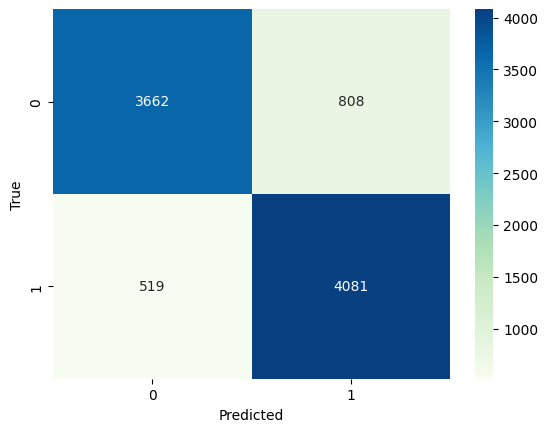

In [84]:
matriz_conf = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(matriz_conf, cmap="GnBu", annot=True, fmt="g")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

<hr/>

# **Generando Predicciones**

In [85]:
def alinear_df_test(df_train: pd.DataFrame, df_test: pd.DataFrame,
                    *,
                    vacio: Union[int, float]=0
) -> pd.DataFrame:
    """
    Esta función hace dos cosas:
        - Crea toda columna presente en 'df_train' (pero no en 'df_test') como una columna nueva
          en 'df_test' y las rellena con el valor 'vacio'.
        - Elimina toda columna que esté en 'df_test' pero no en 'df_train'.

    Se presupone que ambos DataFrames vienen sólo con valores numéricos; normalmente fueron
    convertidos a DataFrames con dummies.
    -
    'df_train': El DataFrame con el que se entrenó el modelo.

    'df_test': El DataFrame con los datos a predecir.

    'vacio': El valor con el que rellenar las columnas insertadas en 'df_test'. Normalmente es `0`,
             pues es el valor que se usa en One Hot Encoding para designar que NO es esa variable.
    """

    df_test_convertida = reducir_columnas(df_train, df_test)

    for col in df_train.columns:
        if col not in df_test.columns:
            nueva_col = np.array([0] * df_test.shape[0]).reshape(-1, 1)
            df_test_convertida[col] = nueva_col

    return df_test_convertida[df_train.columns] # reordenar las columnas con el mismo orden

Acá, para crear la versión con _dummies_ del dataset de testeo, renombramos manualmente las columnas que terminan en '.0', pues vienen de valores de tipo 'float' y las del dataset de entrenamiento son enteros. Si no se llaman igual no son tomadas en cuenta por nuestras funciones y perdemos esos datos.

In [86]:
tests_dummies_desalineados = get_df_dummies(df_tests).rename(columns=(lambda col : (col.removesuffix(".0") if col.endswith(".0") else col)))

In [87]:
test_dummies = alinear_df_test(train_dummies, tests_dummies_desalineados)
test_x, _ = split_in_axes(test_dummies)
predicciones_y = modelo.predict(test_x)

<hr/>

# **Exportando Predicciones**

Hacemos una función interna rápido para exportar en formato CSV.

In [88]:
def _exportar_predicciones(df_test: pd.DataFrame, predicciones: np.ndarray,
                           *,
                           target: str="is_canceled",
                           nombre: "PathLike", # Más bien que se parezca a un nombre de archivo con extensión
                           ruta: "PathLike"="./drive/MyDrive/Colab Notebooks/predictions") -> None:
    """
    Intenta guardar las predicciones en una ruta en Google Drive, para uso interno. Normalmente
    como forma temporal para después subirlo a kaggle.
    Se presupone que el drive ya fue montado junto con los imports.
    -
    'df_test': El DataFrame de los datos a predecir. De acá sacamos la columna 'id'.

    'predicciones': Un `numpy.ndarray` (o lo que salga de `model.predict()`). Estos son los valores
                    que han de llenar la columna del target.

    'target': El nombre de la columna del target. A efectos de este TP1 siempre debería
              ser `"is_canceled"`.

    'nombre': El nombre del archivo en cuestión, de formato `.csv`. Ejemplo: `"predicted1.csv"`.

    'ruta': Ruta del directorio en Drive donde el archivo será guardado.
    """

    path = Path(ruta) / nombre
    df_a_exportar = pd.DataFrame()

    df_a_exportar["id"] = df_test["id"]
    df_a_exportar[target] = predicciones.reshape(-1, 1)

    df_a_exportar.to_csv(path, index=False)